In [31]:
from models.ICA_EM import *
from models.dgp import *
from models.metrics import *
import importlib, sys
importlib.reload(sys.modules['models.ICA_EM'])
importlib.reload(sys.modules['models.dgp'])
importlib.reload(sys.modules['models.metrics'])
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [32]:
n = 10000
J = 6
I = 5
treatmet_true = []
treatment_random = []
treatment_trueA = []
f_score_trueA = []
f_score_randomA = []
mean_squared_error_trueA = []
mean_squared_error_randomA = []
ll_score_trueA = []
ll_score_randomA = []

In [33]:
def norm_funtion(A):
    # [0,0], [1,1] must be one
    if A[0,0] == 0:
        return A[:, 0]
    A_0 = A[:, 0]/A[0,0]
    
    return A_0

In [34]:
data = dgp(prior={"loc" : 0, "scale" : 1/np.sqrt(2)}, noise_dict=  {"loc" : 0, "scale" : 1})
for i in tqdm.tqdm(range(100)):
    data.generate_data(n=n, J=J, I=I, random_state=i)
    treatmet_true.append(data.treatment_effect)
    CausalVarEM_trueA = CausalVarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=1, mode = "each")
    CausalVarEM_trueA.fit(data.data_observed, J = J,
                      noise_params= {"mean" : 0, "std" : 1}, progress_bar= False)
    best_perm, score = f_score(data.mixing_matrix_observed, CausalVarEM_trueA.A)
    f_score_trueA.append(score)
    singals_estimation_VAR = CausalVarEM_trueA.Signals[:,best_perm]
    mean_squared_error_trueA.append(mean_squared_error(data.signals, singals_estimation_VAR))
    ll_score_trueA.append(likelihood_score(data.signals, singals_estimation_VAR, normalize=True))
    treatment_trueA.append(norm_funtion(CausalVarEM_trueA.A[:,best_perm])[1])
    CausalVarEM_randomA = CausalVarEM(update_sigma=False,   true_A= None, tol=1e-4, max_iter=200, random_seed=1, mode = "each")
    CausalVarEM_randomA.fit(data.data_observed, J = J,
                      noise_params= {"mean" : 0, "std" : 1}, progress_bar= False)
    best_perm, score = f_score(data.mixing_matrix_observed, CausalVarEM_randomA.A)
    f_score_randomA.append(score)
    singals_estimation_VAR = CausalVarEM_randomA.Signals[:,best_perm]
    mean_squared_error_randomA.append(mean_squared_error(data.signals, singals_estimation_VAR))
    ll_score_randomA.append(likelihood_score(data.signals, singals_estimation_VAR, normalize=True))
    treatment_random.append(norm_funtion(CausalVarEM_randomA.A[:,best_perm])[1])




100%|██████████| 100/100 [5:17:31<00:00, 190.51s/it]  


In [35]:
df = pd.DataFrame({"f_score_trueA" : f_score_trueA, 
                   "f_score_randomA" : f_score_randomA, 
                   "mean_squared_error_trueA" : mean_squared_error_trueA, 
                   "mean_squared_error_randomA" : mean_squared_error_randomA,
                     "ll_score_trueA" : ll_score_trueA, 
                     "ll_score_randomA" : ll_score_randomA,
                     "treatment_trueA" : treatment_trueA,
                     "treatment_randomA" : treatment_random,
                     "treatment_true" : treatmet_true})

In [36]:
df.to_csv("results/CausalVarEM_init_schema.csv")

In [37]:
# df = pd.read_csv("results/CausalVarEM_init_schema.csv")
print(df.mean())

f_score_trueA                     0.237205
f_score_randomA                   0.632733
mean_squared_error_trueA          1.146546
mean_squared_error_randomA        1.445868
ll_score_trueA               -12974.552197
ll_score_randomA             -12689.459676
treatment_trueA                   0.005157
treatment_randomA                 0.348715
treatment_true                   -0.177828
dtype: float64


## Plot the results


<Axes: xlabel='treatment_true', ylabel='treatment_trueA'>

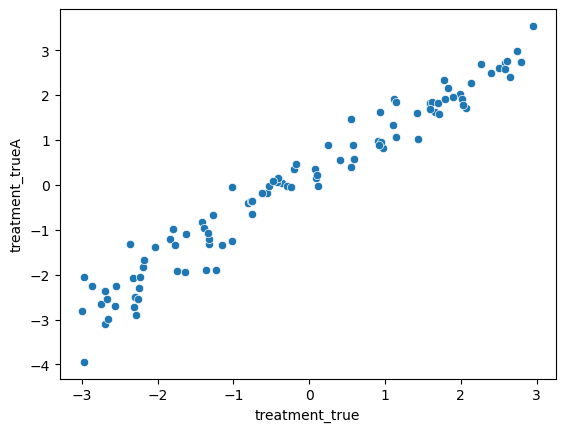

In [41]:
sns.scatterplot(x="treatment_true", y="treatment_trueA", data=df)